In [1]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
# -------------------------------
# Step 1: Load and Clean WHQ_df (with BMI Calculation)
# -------------------------------
WHQ_df = pd.read_csv('WHQ_L.csv')

# Replace the placeholder values (7777, 9999, and blanks) with NaN
WHQ_df.replace({7777: np.nan, 9999: np.nan}, inplace=True)
WHQ_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
WHQ_df.dropna(inplace=True)

# Calculate BMI using the formula: BMI = (weight in lbs / (height in inches)^2) * 703
WHQ_df['BMI'] = (WHQ_df['WHD020'] / (WHQ_df['WHD010'] ** 2)) * 703

# Define a function to classify BMI
def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Healthy Weight'
    elif bmi < 30:
        return 'Overweight'
    elif bmi < 35:
        return 'Class 1 Obesity'
    elif bmi < 40:
        return 'Class 2 Obesity'
    else:
        return 'Class 3 Obesity'

# Apply the classification to create a new column
WHQ_df['BMI_category'] = WHQ_df['BMI'].apply(classify_bmi)

WHQ_df.drop(['WHD010', 'WHD020', 'WHD050' ,'WHQ070', 'BMI' ], axis=1, inplace=True)

print("First few rows of cleaned WHQ_df:")
print(WHQ_df.head())

First few rows of cleaned WHQ_df:
       SEQN     BMI_category
0  130378.0       Overweight
1  130379.0  Class 1 Obesity
2  130380.0       Overweight
3  130384.0  Class 1 Obesity
4  130385.0  Class 1 Obesity


In [3]:
# -------------------------------
# Step 2: Load the Other DataFrames
# -------------------------------
ALQ_df    = pd.read_csv('ALQ_L.csv')
BAX_df    = pd.read_csv('BAX_L.csv')
#BMX_df    = pd.read_csv('BMX_L.csv')
BPQ_df    = pd.read_csv('BPQ_L.csv')
BPXO_df   = pd.read_csv('BPXO_L.csv')
DBQ_df    = pd.read_csv('DBQ_L.csv')
DEMO_df   = pd.read_csv('DEMO_L.csv')
DR1IFF_df = pd.read_csv('DR1IFF_L.csv')
MCQ_df    = pd.read_csv('MCQ_L.csv')
PAQ_df    = pd.read_csv('PAQ_L.csv')
# Note: WHQ_df is already loaded and processed above.

In [4]:
# -------------------------------
# Step 3: Merge All DataFrames on 'SEQN'
# -------------------------------
dfs = [ALQ_df, BAX_df, BPQ_df, BPXO_df, DBQ_df, DEMO_df, DR1IFF_df, MCQ_df, PAQ_df, WHQ_df]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='outer'), dfs)

print("Columns in merged_df:")
print(merged_df.columns)

Columns in merged_df:
Index(['SEQN', 'ALQ111', 'ALQ121', 'ALQ130', 'ALQ142', 'ALQ270', 'ALQ280',
       'ALQ151', 'ALQ170', 'BAXMSTAT',
       ...
       'MCQ230D', 'OSQ230', 'PAD790Q', 'PAD790U', 'PAD800', 'PAD810Q',
       'PAD810U', 'PAD820', 'PAD680', 'BMI_category'],
      dtype='object', length=246)


In [5]:
# -------------------------------
# Step 4: Clean Merged Data
# -------------------------------
# Drop rows missing the target 'BMI_category'
merged_df.dropna(subset=['BMI_category'], inplace=True)

# Fill missing values with 0 for all remaining columns
merged_df.fillna(0, inplace=True)



In [6]:
merged_df['BMI_category'].head()

0    Overweight
1    Overweight
2    Overweight
3    Overweight
4    Overweight
Name: BMI_category, dtype: object

In [7]:
# -------------------------------
# Step 5: Prepare Features and Target
# -------------------------------
y = merged_df['BMI_category']
X = merged_df.drop(['BMI_category', 'SEQN'], axis=1)

# One-hot encode categorical variables in X
X = pd.get_dummies(X)

In [8]:
# -------------------------------
# Step 6: Stratified Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# -------------------------------
# Step 7: Scaling Features
# -------------------------------
scaler = StandardScaler()

# Scale the training data and transform test data, preserving column names
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [10]:
# -------------------------------
# Step 8: Apply SMOTE to Balance the Training Data
# -------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("Training set distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

print("\nTest set distribution (original composition):")
print(y_test.value_counts())

Training set distribution after SMOTE:
BMI_category
Overweight         21512
Class 1 Obesity    21512
Class 2 Obesity    21512
Healthy Weight     21512
Class 3 Obesity    21512
Underweight        21512
Name: count, dtype: int64

Test set distribution (original composition):
BMI_category
Overweight         5379
Healthy Weight     5042
Class 1 Obesity    2941
Class 2 Obesity    1297
Class 3 Obesity     996
Underweight         280
Name: count, dtype: int64


In [11]:
# -------------------------------
# Step 9: Baseline Random Forest Model (using resampled training data)
# -------------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [13]:
# -------------------------------
# Step 10: Permutation Feature Importance on Test Set
# -------------------------------
perm_importance = permutation_importance(
    rf, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='f1_macro'
)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_14_features = X_train_scaled.columns[sorted_idx][:14]
print("Top 14 Features:")
print(top_14_features)

Top 14 Features:
Index(['BPAOCSZ', 'RIDAGEYR', 'PAD680', 'PAD820', 'BPQ101D', 'BPQ080',
       'BPQ020', 'BPQ030', 'MCQ195', 'DBQ424', 'DBQ330', 'PAD790U_b'D'',
       'RIAGENDR', 'DMDHHSIZ'],
      dtype='object')


In [16]:
# -------------------------------
# Step 11: Retrain Random Forest Using Top 14 Features
# -------------------------------

# Subset the data to include only the top 14 features
X_train_top14 = X_train_scaled[top_14_features]
X_test_top14  = X_test_scaled[top_14_features]

# Apply SMOTE to balance the training data (using top 14 features)
X_train_top14_res, y_train_top14_res = smote.fit_resample(X_train_top14, y_train)

# Initialize and train the RandomForestClassifier
rf_top14 = RandomForestClassifier(random_state=42)
rf_top14.fit(X_train_top14_res, y_train_top14_res)

# Make predictions on the training set and test set
y_pred_train_top14 = rf_top14.predict(X_train_top14_res)
y_pred_test_top14  = rf_top14.predict(X_test_top14)

# Print classification report for the training set
print("Training Classification Report using Top 14 Features:")
print(classification_report(y_train_top14_res, y_pred_train_top14))

# Print classification report for the test set
print("\nTest Classification Report using Top 14 Features:")
print(classification_report(y_test, y_pred_test_top14))


Training Classification Report using Top 14 Features:
                 precision    recall  f1-score   support

Class 1 Obesity       1.00      0.99      1.00     21512
Class 2 Obesity       0.99      1.00      1.00     21512
Class 3 Obesity       1.00      1.00      1.00     21512
 Healthy Weight       0.99      0.98      0.99     21512
     Overweight       0.99      0.99      0.99     21512
    Underweight       0.98      1.00      0.99     21512

       accuracy                           0.99    129072
      macro avg       0.99      0.99      0.99    129072
   weighted avg       0.99      0.99      0.99    129072


Test Classification Report using Top 14 Features:
                 precision    recall  f1-score   support

Class 1 Obesity       0.97      0.96      0.97      2941
Class 2 Obesity       0.95      0.96      0.96      1297
Class 3 Obesity       0.96      0.97      0.96       996
 Healthy Weight       0.97      0.96      0.97      5042
     Overweight       0.97      0.96

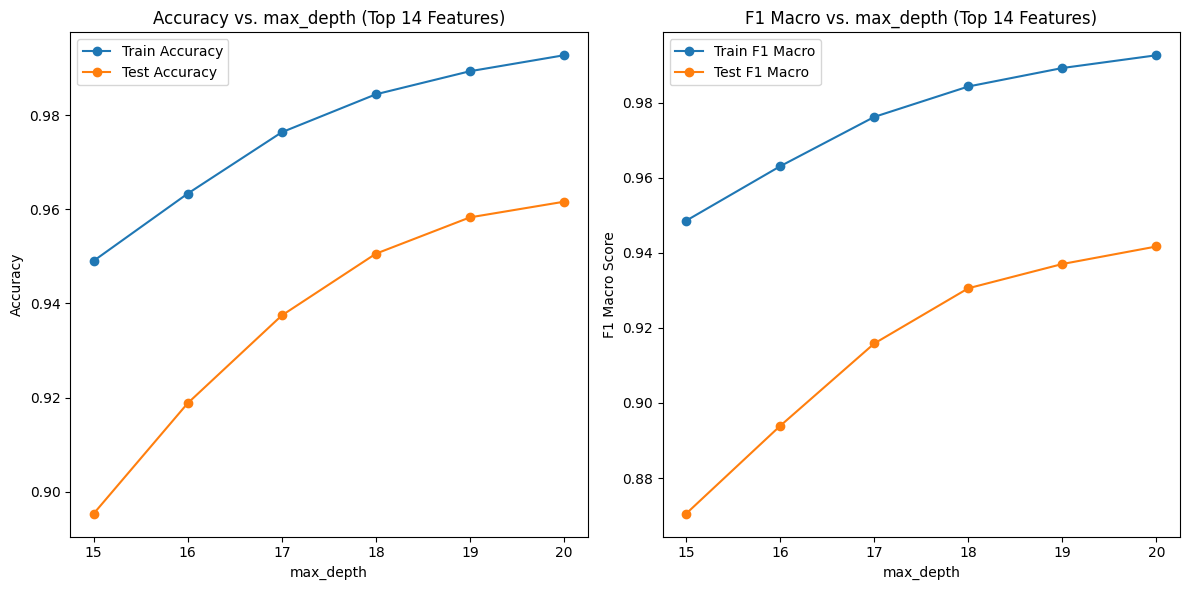

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# Subset the data to include only the top 14 features
X_train_top14 = X_train_scaled[top_14_features]
X_test_top14 = X_test_scaled[top_14_features]

# Apply SMOTE to balance the training data for these features
X_train_top14_res, y_train_top14_res = smote.fit_resample(X_train_top14, y_train)

# List of max_depth values to try
max_depth_values = [10,11,12,13,14,15, 16, 17, 18, 19, 20]

train_accuracies = []
test_accuracies = []
train_f1s = []
test_f1s = []

# Loop over different max_depth values using only the top 14 features
for md in max_depth_values:
    # Initialize a new RandomForestClassifier with the given max_depth
    rf_temp = RandomForestClassifier(random_state=42, max_depth=md, n_jobs=-1)
    rf_temp.fit(X_train_top14_res, y_train_top14_res)
    
    # Predict on the training and test sets
    y_pred_train_temp = rf_temp.predict(X_train_top14_res)
    y_pred_test_temp  = rf_temp.predict(X_test_top14)
    
    # Record the accuracy and f1_macro scores
    train_accuracies.append(accuracy_score(y_train_top14_res, y_pred_train_temp))
    test_accuracies.append(accuracy_score(y_test, y_pred_test_temp))
    train_f1s.append(f1_score(y_train_top14_res, y_pred_train_temp, average='macro'))
    test_f1s.append(f1_score(y_test, y_pred_test_temp, average='macro'))

# Plot the performance metrics
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
x_vals = [md for md in max_depth_values]
plt.plot(x_vals, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(x_vals, test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. max_depth (Top 14 Features)')
plt.legend()

# F1 Macro Score plot
plt.subplot(1, 2, 2)
plt.plot(x_vals, train_f1s, marker='o', label='Train F1 Macro')
plt.plot(x_vals, test_f1s, marker='o', label='Test F1 Macro')
plt.xlabel('max_depth')
plt.ylabel('F1 Macro Score')
plt.title('F1 Macro vs. max_depth (Top 14 Features)')
plt.legend()

plt.tight_layout()
plt.show()


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Subset the training and test data to include only the top 14 features
X_train_top14 = X_train_scaled[top_14_features]
X_test_top14  = X_test_scaled[top_14_features]

# Apply SMOTE to balance the training data using the top 14 features
X_train_top14_res, y_train_top14_res = smote.fit_resample(X_train_top14, y_train)

# Initialize the RandomForestClassifier with max_depth=10
rf_best = RandomForestClassifier(max_depth=13, random_state=42, n_jobs=-1)

# Fit the model on the SMOTE-resampled training data (using top 14 features)
rf_best.fit(X_train_top14_res, y_train_top14_res)

# Predict on the training and test sets
y_pred_train_best = rf_best.predict(X_train_top14_res)
y_pred_test_best  = rf_best.predict(X_test_top14)

# Print the classification reports for training and test sets
print("Training Performance with max_depth=13 (Top 14 Features):")
print(classification_report(y_train_top14_res, y_pred_train_best))

print("Test Performance with max_depth=13 (Top 14 Features):")
print(classification_report(y_test, y_pred_test_best))


Training Performance with max_depth=13 (Top 14 Features):
                 precision    recall  f1-score   support

Class 1 Obesity       0.88      0.87      0.87     21512
Class 2 Obesity       0.87      0.94      0.90     21512
Class 3 Obesity       0.95      0.96      0.95     21512
 Healthy Weight       0.85      0.88      0.86     21512
     Overweight       0.88      0.73      0.80     21512
    Underweight       0.92      0.98      0.95     21512

       accuracy                           0.89    129072
      macro avg       0.89      0.89      0.89    129072
   weighted avg       0.89      0.89      0.89    129072

Test Performance with max_depth=13 (Top 14 Features):
                 precision    recall  f1-score   support

Class 1 Obesity       0.83      0.84      0.83      2941
Class 2 Obesity       0.69      0.91      0.79      1297
Class 3 Obesity       0.83      0.92      0.87       996
 Healthy Weight       0.85      0.87      0.86      5042
     Overweight       0.90   

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# -------------------------------
# Final RandomForest Model Training Using Manually Selected Features
# -------------------------------

# Manually selected features (replace these placeholders with your chosen feature names)
manual_features_rf = [
    'RIDAGEYR',
    'INDFMPIR',
    'WTMEC2YR',
    'BPXOPLS3',
    'BPXOPLS2',
    'BPXOPLS1',
    'DR1DBIH',
    'WTDRD1',
    'BPXOSY2',
    'BPXOSY3',
    'BPXOSY1',
    'DR1ILINE',
    'WTDR2D',
    'PAD680'
]


# Subset the training and test data to include only the manually selected features
X_train_rf = X_train_res[manual_features_rf]
X_test_rf = X_test_scaled[manual_features_rf]

# Initialize the RandomForestClassifier with a specified max_depth (e.g., 10)
rf_best = RandomForestClassifier(max_depth=13, random_state=42, n_jobs=-1)

# Fit the model on the SMOTE-resampled training data (using the manually selected features)
rf_best.fit(X_train_rf, y_train_res)

# Predict on the training and test sets
y_pred_train_best = rf_best.predict(X_train_rf)
y_pred_test_best  = rf_best.predict(X_test_rf)

# Print the classification reports
print("Training Performance with max_depth=13 (RandomForest with manual features):")
print(classification_report(y_train_res, y_pred_train_best))

print("Test Performance with max_depth=13 (RandomForest with manual features):")
print(classification_report(y_test, y_pred_test_best))


Training Performance with max_depth=13 (RandomForest with manual features):
                 precision    recall  f1-score   support

Class 1 Obesity       0.92      0.97      0.94     21512
Class 2 Obesity       0.97      0.96      0.96     21512
Class 3 Obesity       0.94      0.97      0.96     21512
 Healthy Weight       0.98      0.94      0.96     21512
     Overweight       0.97      0.94      0.95     21512
    Underweight       0.98      0.98      0.98     21512

       accuracy                           0.96    129072
      macro avg       0.96      0.96      0.96    129072
   weighted avg       0.96      0.96      0.96    129072

Test Performance with max_depth=13 (RandomForest with manual features):
                 precision    recall  f1-score   support

Class 1 Obesity       0.89      0.96      0.92      2941
Class 2 Obesity       0.93      0.95      0.94      1297
Class 3 Obesity       0.81      0.96      0.88       996
 Healthy Weight       0.97      0.92      0.95    